## 4 Pre-processing and Training<a id='4_Pre-processing_and_Training'></a>

## 4.1 Contents<a id='4.1_Contents'></a>
* [4 Pre-Processing and Training Data](#4_Pre-Processing_and_Training_Data)
  * [4.1 Contents](#4.1_Contents)
  * [4.2 Introduction](#4.2_Introduction)
  * [4.3 Imports](#4.3_Imports)
  * [4.4 Loading the Data](#4.4_Loading_the_Data)
  * [4.5 Extract Borrower Data](#4.5_Extract_Borrower_Data)
  * [4.6 Splitting Indicator and Numerical Features](#4.6_Splitting_Indicator_and_Numerical_Features)
  * [4.7 Creating Dummy Features and Scaling Numeric Data](#4.7_Creating_Dummy_Features_and_Scaling_Numeric_Data)
  * [4.8 Train/Test Split](#4.8_Train/Test_Split)
  * [4.9 Feature Correlation](#4.9_Feature_Correlation)
  * [4.10 Building a Quick Logistic Regression Model](#4.10_Building_a_Quick_Logistic_Regression_Model)
  * [4.11 Assess Performance](#4.11_Assess_Performance)
  * [4.12 Summary](#4.12_Summary)

## 4.2 Introduction<a id='4.2_Introduction'></a>

In this notebook we'll begin building machine learning models. Before even starting with learning a machine learning model, let's start by considering how useful the mean value is as a predictor. Think of the first model as a baseline performance comparitor for any subsequent model. We'll then build up the process of efficiently and robustly creating and assessing models against it.

## 4.3 Imports<a id='4.3_Imports'></a>

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,f1_score,precision_score, recall_score
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import __version__ as sklearn_version
from sklearn import svm, datasets
from sklearn.metrics import plot_confusion_matrix
import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
os.chdir(r'C:\Users\daenj\OneDrive\Desktop\Datasets\Capstone 2021')
os.getcwd()

'C:\\Users\\daenj\\OneDrive\\Desktop\\Datasets\\Capstone 2021'

## 4.4 Loading the Data<a id='4.4_Loading_the_Data'></a>

We're going to remove the numerical data and create a new data frame with only the object data types. This will be used later when creating dummy features.

In [3]:
data = pd.read_csv('cleaned_data.csv')
data = data.drop(columns='Unnamed: 0')
data = pd.DataFrame(data)

In [4]:
object_data = data.select_dtypes(include = ['object'])

## 4.5 Extracting Borrower Data<a id='4.5_Extracting_Borrower_Data'></a>

Here we're splitting the borrowers based on whether they have payment issues or not.

In [5]:
payment_issues = data[data.TARGET == 1]
no_issues = data[data.TARGET == 0]

In [6]:
payment_issues.shape

(24825, 41)

In [7]:
no_issues.shape

(282686, 41)

## 4.6 Splitting Indicator and Numerical Features<a id='4.6_Splitting_Indicator_and_Numerical_Features'></a>

In this section, the indicator and numerical features are split from borrowers with a target of 1 and 0. (Payment issues and no payment issues) Since the object data types was extracted from the whole data set, we won't use the object variables created here, only the float variables.

In [8]:
payment_issues_float = payment_issues.select_dtypes(include = ['int', 'float'])
payment_issues_object = payment_issues.select_dtypes(include=['object'])

In [9]:
no_issues_float = no_issues.select_dtypes(include = ['int', 'float'])
no_issues_object = no_issues.select_dtypes(include=['object'])

In [10]:
print(no_issues_float.columns)
print(no_issues_object.columns)

Index(['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
       'DAYS_ID_PUBLISH', 'CNT_FAM_MEMBERS', 'DAYS_LAST_PHONE_CHANGE'],
      dtype='object')
Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE',
       'DAYS_BIRTH_BINS', 'INCOME_VAL'],
      dtype='object')


## 4.7 Creating Dummy Features<a id='4.7_Creating_Dummy_Features'></a>

This next step concatenates the float variables from both groups of borrowers. 

In [11]:
frames = [no_issues_float, payment_issues_float]
float_data = pd.concat(frames)

Let's create dummy features for our categorical data. We'll use the object variable created at the beginning of the notebook.

In [12]:
object_data = pd.get_dummies(object_data, drop_first=False)

Here we are concatenating the float data and the object data into one dataset.

In [13]:
concat_data = pd.concat([float_data, object_data], axis=1)

## 4.8 Train/Test Split<a id='4.8_Train/Test_Split'></a>

This Train/Test split has 30% of the data on the test split. As stated earlier, our target is either a 1 or 0 for all of the borrowers. 

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    concat_data,
    data['TARGET'],
    test_size=0.3, 
    random_state=0)

## 4.9 Feature Correlation<a id='4.9_Feature_Correlation'></a>

This section deals with highly correlated features and their removal from the model. Features that have greater than a 95% correlation will be dropped.

In [15]:
correlated_features = set()
correlation_matrix = concat_data.corr()

In [16]:
for i in range(len(correlation_matrix .columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.95:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [17]:
#These are the features that will be dropped.
print(correlated_features)

{'FLAG_OWN_REALTY_Y', 'FLAG_OWN_CAR_Y', 'NAME_CONTRACT_TYPE_Revolving loans', 'CODE_GENDER_M', 'AMT_GOODS_PRICE', 'ORGANIZATION_TYPE_XNA', 'NAME_INCOME_TYPE_Pensioner'}


In [18]:
X_train.drop(labels=correlated_features, axis=1, inplace=True)
X_test.drop(labels=correlated_features, axis=1, inplace=True)

## 4.10 Building A Quick Logistic Regression Model<a id='4.10_Building_A_Quick_Logistic_Regression_Model'></a>

I've built a quick linear regression model with an accompanying confusion matrix and classification report.

In [19]:
X_defaults_median = X_train.median()

In [20]:
X_tr = X_train.fillna(X_defaults_median)
X_te = X_test.fillna(X_defaults_median)

In [21]:
scaler = StandardScaler()
scaler.fit(X_tr)
X_tr_scaled = scaler.transform(X_tr)
X_te_scaled = scaler.transform(X_te)

In [22]:
lm = LogisticRegression().fit(X_tr_scaled, y_train)

In [23]:
y_tr_pred = lm.predict(X_tr_scaled)
y_te_pred = lm.predict(X_te_scaled)

## 4.11 Assess Performance<a id='4.11_Assess_Performance'></a>

Let's quickly assess the performance of various models!

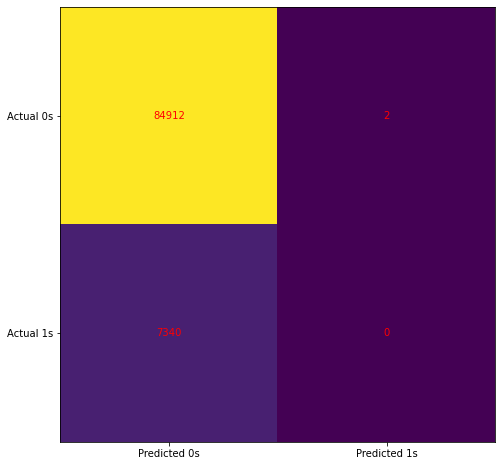

In [35]:
cm = confusion_matrix(y_test, y_te_pred) 

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

This confusion matrix states that this model correctly predicted 84912 true positives and 2 false positives. There were 7340 false negatives and no true negatives. Let's take a look at the classification report.

In [33]:
print(classification_report(y_test, y_te_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     84914
           1       0.00      0.00      0.00      7340

    accuracy                           0.92     92254
   macro avg       0.46      0.50      0.48     92254
weighted avg       0.85      0.92      0.88     92254



The precision for this model sits at 92%. This tells us that out of the 84914 borrowers that were labeled, the proportion that were labeled correctly is 92%.

Let's compare the results of a logistic regression model to other types of models.

In [25]:
def ml_model(X_train,X_test, y_train, y_test):
  MLA = [LogisticRegression(),KNeighborsClassifier(),DecisionTreeClassifier(),GaussianNB()]
  MLA_columns = []
  MLA_compare = pd.DataFrame(columns = MLA_columns)
  row_index = 0
  for alg in MLA:
    predicted = alg.fit(X_train, y_train).predict(X_test)
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index,'Model Name'] = MLA_name
    MLA_compare.loc[row_index, 'Train Accuracy'] = round(alg.score(X_train, y_train), 2)
    MLA_compare.loc[row_index, 'Test Accuracy'] = round(alg.score(X_test, y_test), 2)
    MLA_compare.loc[row_index, 'Precision'] = round(precision_score(y_test, predicted),2)
    MLA_compare.loc[row_index, 'Recall'] = round(recall_score(y_test, predicted),2)
    MLA_compare.loc[row_index, 'F1 score'] = round(f1_score(y_test, predicted),2)
    row_index+=1
  MLA_compare.sort_values(by = ['Test Accuracy'], ascending = False, inplace = True)    
  return MLA_compare  
ml_model(X_train,X_test, y_train, y_test)

,Model Name,Train Accuracy,Test Accuracy,Precision,Recall,F1 score
0,LogisticRegression,0.92,0.92,0.00,0.00,0.00
1,KNeighborsClassifier,0.92,0.91,0.17,0.02,0.03
3,GaussianNB,0.91,0.91,0.05,0.00,0.01
2,DecisionTreeClassifier,1.00,0.84,0.10,0.12,0.11


Train accuracy is above 90% for all the models. Test accuracy only goes down with the decision tree model. It falls from 100% train accuracy to 84%. The KNC model has the second largest precision percentage at 17%, and the decision tree model has a 10% precision. Out of the KNC, Gaussian, and decision tree models, the decision tree model has the highest recall and f1-score.

## 4.12 Summary<a id='4.12_Summary'></a>

Numerical and categorical features were split up into two different datasets. After creating dummy variables for the object data, a new, concatenated dataframe was created that included the float data and the object data with the dummy variables. A train/test split was created before investigating feature correlations. Features that were highly correlated (above 95%) were removed from the dataset before building the logistic regression model. A confusion matrix and classification report were created to assess the results. 